## Digit Classification with Nearest Neighbors

### Chris Tralie

Today we talked about <b>supervised learning</b>, which is the process by learning from a set of <b>labeled examples</b>, or examples that have been sorted into different classes beforehand.  We're not always fortunate enough to have data that's labeled like this, but when we do, there are a variety of techniques we can use to learn models of the different classes.  Actually, everything we've done in this class so far can be considered supervised learning, including learning from <a href = "../../Assignments/HW3_Markov">Markov chains trained on text</a> to <a href = "../Week5_BagOfWords">Naive Bayes bag of words</a> and <a href = "../Week6_GradSchoolAdmissions">Gaussian Naive Bayes</a>.  In every application we looked at with these techniques, we <b>trained</b> on our labeled examples and then we tested on some new unseen data that wasn't included in the training set.

In this exercise today, we explore a new supervised learning technique known as <b>nearest neighbors</b>.  If we have a way of measuring a <b>distance</b> between two different data points, then we can apply this technique.  For example, let's suppose we had a labeled set of data points in two classes: red circles and blue squares.  Then, let's say we wanted to guess which of the two classes some new data point was in.  We'll depict this data point as a black triangle, as shown below

<img src = "NN2Dexample.svg">


The <b>K-nearest neighbors</b> technique simply finds the <b>K</b> closest labeled examples, as measured by the distance, and uses them to vote on the class identity of this new point.  In the above example, we choose <b>K = 5</b> for the 5 nearest neighbors, and we happen to get 4 votes for a red circle and 1 vote for a blue square, so we would label this new data point as a red circle.

Overall, we can think of nearest neighbors as a supervised learning technique that <b>memorizes</b> examples.  This means it's only as good as the examples, and it will do better with a higher number and variety of examples, which we don't always have access to.  By contrast, other learning techniques will try to better <b>generalize</b> some knowledge to new examples.  But we'll start with this "memorizer" first.

As simple as this technique may seem, it can work very well in practice.  Below we'll show k-nearest neighbors on an example of 28x28 images of drawn digits, where the labeled examples are obtained from the <a href = "https://en.wikipedia.org/wiki/MNIST_database">MNIST database</a>.  In this case, there are 10 unique classes for the digits between 0 and 9, inclusive. Let's first load in our imports and load in all of the MNIST digits.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import scipy.stats
from skimage.transform import resize
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

In [2]:
# Load in all digits
res = 28
digits = []
for i in range(10):
    digits.append([])
    I = skimage.io.imread("Digits/{}.png".format(i))/255.0
    row = 0
    col = 0
    while row < I.shape[0]:
        col = 0
        while col < I.shape[1]:
            img = I[row:row+res, col:col+res]
            if np.sum(img) > 0:
                digits[i].append(img)
            col += res
        row += res
    print(len(digits[i]), "unique ", i, " digits")

5923 unique  0  digits
6742 unique  1  digits
5958 unique  2  digits
6131 unique  3  digits
5842 unique  4  digits
5421 unique  5  digits
5918 unique  6  digits
6265 unique  7  digits
5851 unique  8  digits
5949 unique  9  digits


The digits are setup in a 2D array so that <code>digits[i][j]</code> gives the $j^{\text{th}}$ example of digit $i$.  Each digit is itself a $28 \times 28$ 2D array of grayscale values between 0 and 1.

Next, let's try to think about how to define a distance between two digit images.  First, let's look at the range of values in a digit.  We'll pick out the first 0 as an example

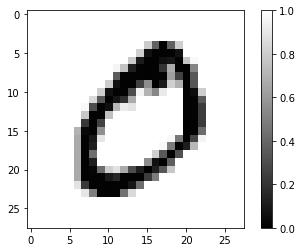

In [3]:
plt.imshow(digits[0][0], cmap='gray')
plt.colorbar()

Sam had the idea in class that we might try to compare which pixels where black in one image compared to another.  To do this, we should only pick all pixels that are under a certain threshold.  This is called <b>binary quantization</b>.  For example, let's suppose the threshold is 0.4.  Here's how we might do this for the image above

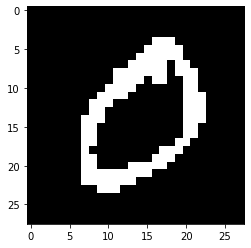

In [4]:
# Look at 200th example of a 3
thresh = 0.4
Y = np.zeros((28, 28))
for i in range(28):
    for j in range(28):
        if digits[0][0][i][j] > thresh:
            Y[i][j] = 0
        else:
            Y[i][j] = 1

plt.imshow(Y, cmap='gray')

Below is a simpler way to accomplish thresholding with a single line of code using <b>numpy broadcasting</b>.  Not only is the code shorter, but if you can stick to numpy, the code will run much faster because it's compiled C/Fortran

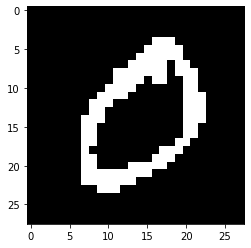

In [5]:
Y = digits[0][0] < thresh
plt.imshow(Y, cmap='gray')

To compare two digits, we can threshold both of them and compute the <b>Hamming distance</b> between them, or the number of overlapping pixels that are different after thresholding.   The Hamming distance between an 2D array $X$ and a 2D array $Y$ is defined as

### $\sum_{i, j} |X[i][j] - Y[i][j]|$

Let's compare the first 1 to the first 7 this way, using numpy subtract broadcasting and <code>np.sum</code> to avoid a loop

Text(0.5, 1.0, 'Dist = 110.0')

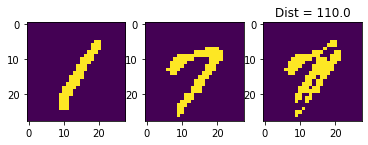

In [6]:
# We have to multiply these by 1.0 to cast them to floats and avoid an 
# annoying "- operator is not supported for boolean variables"
X = 1.0*(digits[1][0] < thresh) 
Y = 1.0*(digits[7][0] < thresh)
diff = np.abs(X-Y)
dist = np.sum(diff)

plt.subplot(131)
plt.imshow(X)
plt.subplot(132)
plt.imshow(Y)
plt.subplot(133)
plt.imshow(diff)
plt.title("Dist = {}".format(dist))

Now we're finally ready to apply this to K-nearest neighbors.  We'll define a function handle for this distance, as well as another distance that I had in mind, the <b>Euclidean distance</b>, which is defined as 

### $\sqrt{\sum_{i, j} (X[i, j] - Y[i, j])^2}$

You'll see that these each work pretty well if you try them out below, but the Euclidean distance has the advantage that we don't have to choose a threshold as a parameter.  We'll compare them both below

In [7]:
def thresh_hamming_dist(X, Y, thresh=0.4):
    return np.sum(np.abs(1.0*(X < thresh) - 1.0*(Y < thresh)))

def euclidean_dist(X, Y):
    return np.sqrt(np.sum((X-Y)**2))

We'll setup a little interactive canvas where we can draw digits and retrieve their K nearest neighbors.  We'll use <code><a href = "https://numpy.org/doc/stable/reference/generated/numpy.argsort.html">np.argsort</a></code> to help us find the nearest neighbors.  Try it out for yourself!

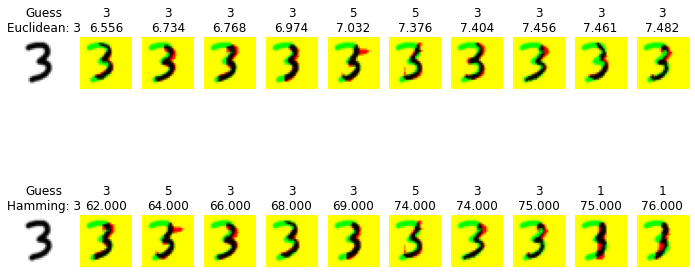

In [8]:
width = 200  # canvas width
height = 200 # canvas height
center = height//2

K = 10 # Number of nearest neighbors to consider

def classify():
    I = np.array(digit_image) # The image that we drew
    I = I[:, :, 0]
    dim = digits[0][0].shape[0]
    I = resize(I, (dim, dim), anti_aliasing=True)
    
    res = 3
    plt.figure(figsize=(12, 6))
    plot_num = 2
    
    
    ## TODO: Find k nearest neighbors by looping through all digit examples
    offset = 1
    for dist_fn, name in zip([euclidean_dist, thresh_hamming_dist], ["Euclidean", "Hamming"]):
        dists = [] # Store a list of distances
        idxs = [] # That's parallel with a list of tuples of (digit #, example index)
        for i in range(10):
            for j in range(len(digits[i])):
                dists.append(dist_fn(I, digits[i][j]))
                idxs.append((i, j))
        
        # Plot the guesses
        guesses = []
        for idx in np.argsort(dists)[0:K]: # Use argsort to find the closest ones
            d = dists[idx]
            digit = idxs[idx][0]
            j = idxs[idx][1]
            guesses.append(digit)
            plt.subplot(2, K+1, plot_num)
            J = np.zeros((I.shape[0], I.shape[1], 3))
            J[:, :, 0] = I
            J[:, :, 1] = digits[digit][j]
            plt.imshow(J)
            plt.title("{}\n{:.3f}".format(digit, d))
            plt.axis("off")
            plot_num += 1
        guess = scipy.stats.mode(guesses)[0][0] # Guess is the vote from all nearest neighbors
        # Plot the original digit with the mode of the guesses
        plt.subplot(2, K+1, offset)
        plt.imshow(I, cmap='gray')
        plt.title("Guess\n{}: {}".format(name, guess))
        plt.axis("off")
        offset = K+2
        plot_num = K+3
        
    root.destroy()

def paint(event):
    """
    Paint on the PIL canvas and the Tkinter canvas in parallel
    Draw canvas will be saved, while Tkinter canvas shows
    the user what they are drawing
    """
    bs = 10
    x1, y1 = (event.x - bs), (event.y - bs)
    x2, y2 = (event.x + bs), (event.y + bs)
    canvas.create_oval(x1, y1, x2, y2, fill="black")
    draw.ellipse([x1, y1, x2, y2], fill="#000000")

root = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(root, width=width, height=height, bg='white')
canvas.pack()

# Create a PIL image and a drawer object
digit_image = PIL.Image.new("RGB", (width, height), (255, 255, 255))
draw = ImageDraw.Draw(digit_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="classify",command=classify)
button.pack()

root.mainloop()

Finally, it's worth noting that the above approach is a brute force nearest neighbors approach that uses sorting.  There are tons of ways to improve this.  One of them is to use a data structure known as a <a href = "https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html#scipy.spatial.KDTree.query">KD Tree</a>, which is able to hone in on the region of the space that contains nearest neighbors much more quickly without checking every example.  It is roughly analagous to <a href = "https://ursinus-cs371-s2021.github.io/Modules/Module8/Exercise0">binary search</a> performed spatially.  Sadly, KD Trees to suffer from what's known as the "curse of dimensionality."  Therefore, one often uses an <a href = "https://github.com/spotify/annoy">approximate nearest neighbors</a> scheme.